# Boltzmann machines

In [21]:
import numpy as np
import scipy.linalg as la
from sklearn.datasets import fetch_mldata
import os
import io
import PIL.Image as img
from IPython.display import display, Image
import matplotlib.pyplot as plt
%matplotlib inline

## Sampling from a general Boltzmann machine

Set some constants to define simulation behaviour

In [18]:
DATA_DIR = os.environ.get('DATA_DIR', None) # directory to cache MNSIT data in,
THRESHOLD = 150 # value to threshold vectors at to get
N_PER_CLASS = 10 # number of data items to use for each of the 10 digit classes
SEED = 1234 # seed for pseudo-random number generator
N_RUN = 30 # how many sample runs to do in parallel
N_SWEEP = 400 # how many Gibbs sweeps to do for each sample run
PAD = 2 # padding to put between adjacent sample images
MOSAIC_STEP = 20 # number of sample steps between adjacent images displayed in mosaic
PARAM_MULT = 5 # scale factor to multiply parameters by

Get MNIST data using scikit-learn fetcher function. Data is cached locally in DATA_DIR to speed up future access.

In [ ]:
mnist = fetch_mldata('MNIST original', data_home=DATA_DIR)
n_data, n_dim = mnist.data.shape
print("Data dimensionality: {0}\nNumber of data items: {1}".format(n_data, n_dim))

Function for calculating example BM parameters using Hopfield network pseudo-inverse weight rule

In [5]:
def hopfield_params(X, epsilon=1e-5):
    x_mn = X.mean(0)
    X_zm = X - x_mn
    W = 2 * X_zm.T.dot(la.solve(X_zm.dot(X_zm.T) + np.eye(X.shape[0]) * epsilon, X_zm))
    b = 2 * x_mn - W.dot(x_mn) - 1
    W = W - np.diag(W.diagonal())
    return W, b

Extract subset of data by taking first N_PER_CLASS examples of each of 10 classes and use to calculate Hopfield network parameters, then scaling these to make modes more defined.

In [6]:
X = np.array([mnist.data[mnist.target == i][:N_PER_CLASS] for i in range(10)]).reshape(10*N_PER_CLASS, n_dim)
X = X > THRESHOLD
y = np.repeat(np.arange(10), N_PER_CLASS)
W, b = hopfield_params(X)
W *= PARAM_MULT
b *= PARAM_MULT
print("Weight matrix shape: {0}\nBias vector shape: {1}".format(W.shape, b.shape))
print("Weight matrix min/max/mean/std: {0:.4f}/{1:.4f}/{2:.4f}/{3:.4f}".format(W.min(), W.max(), W.mean(), W.std()))
print("Bias vector min/max/mean/std: {0:.4f}/{1:.4f}/{2:.4f}/{3:.4f}".format(b.min(), b.max(), b.mean(), b.std()))

Weight matrix shape: (784, 784)
Bias vector shape: (784,)
Weight matrix min/max/mean/std: -0.9709/1.8813/0.0035/0.1075
Bias vector min/max/mean/std: -7.7373/-1.5899/-4.8212/0.6474


Functions for doing a one-unit sequential Gibbs sampling sweep

In [7]:
def sigmoid(x):
    return 1./(1+np.exp(-x))

def gibbs_sample_sweep(X, W, b, prng=np.random.RandomState()):
    X = X.copy()
    for i in range(X.shape[1]):
        p = sigmoid(X.dot(W[:,i]) + b[i])
        X[:,i] = prng.rand(X.shape[0]) > p
    return X

Set up array for recording sampler state after each sweep and randomly initialise initial state.

In [8]:
prng = np.random.RandomState(SEED)
Xs = np.empty((N_SWEEP, N_RUN, n_dim)) * np.nan
Xs[0] = prng.rand(N_RUN, n_dim) > 0.5

Do N_SWEEP Gibbs sweeps through state and record state after each sweep, running N_RUN runs in parallel.

In [ ]:
for s in range(1, N_SWEEP):
    Xs[s] = gibbs_sample_sweep(Xs[s-1], W, b, prng)

Construct a mosaic of sample images with rows corresponding to the different runs and images within row from left to right being at later iterations with each adjacent image separated by MOSAIC_STEP sweeps.

In [16]:
h, w = 28, 28
mosaic_arr = np.zeros(((h+PAD)*N_RUN - PAD, (w+PAD)*(N_SWEEP/MOSAIC_STEP) - PAD))
for r in range(N_RUN):
    for s in range(N_SWEEP/MOSAIC_STEP):
        mosaic_arr[r*(h+PAD):r*(h+PAD)+h, s*(w+PAD):s*(w+PAD)+w] = Xs[s*MOSAIC_STEP, r, :].reshape(h, w)

Display sample mosaic. Unfortunately the samples don't look much like digits. This does not just seem to just due to bad mixing by the sampler but instead the distribution learned using the Hopfield learning rule does not appear created modes corresponding to the digit classes (perhaps not unsuprisingly given the large number of input patterns compared to the capacity of the network and the lack of any hidden units).

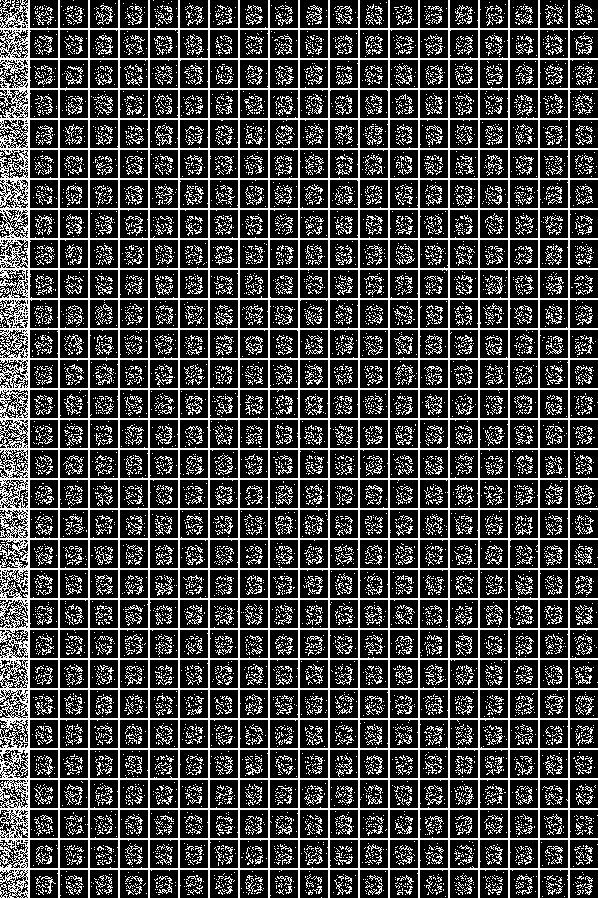

In [20]:
mosaic_im = img.fromarray(np.uint8((1-mosaic_arr)*255))
mosaic_data = io.BytesIO()
mosaic_im.save(mosaic_data, format='png')
display(Image(data=mosaic_data.getvalue(), format='png'))

Can also visualise sample runs by plotting as stacked series of flattened vectors - this makes it even more obvious that the model is not producing interesting samples with it staying close to the configuration favoured by the bias vector plus a bit of random noise.

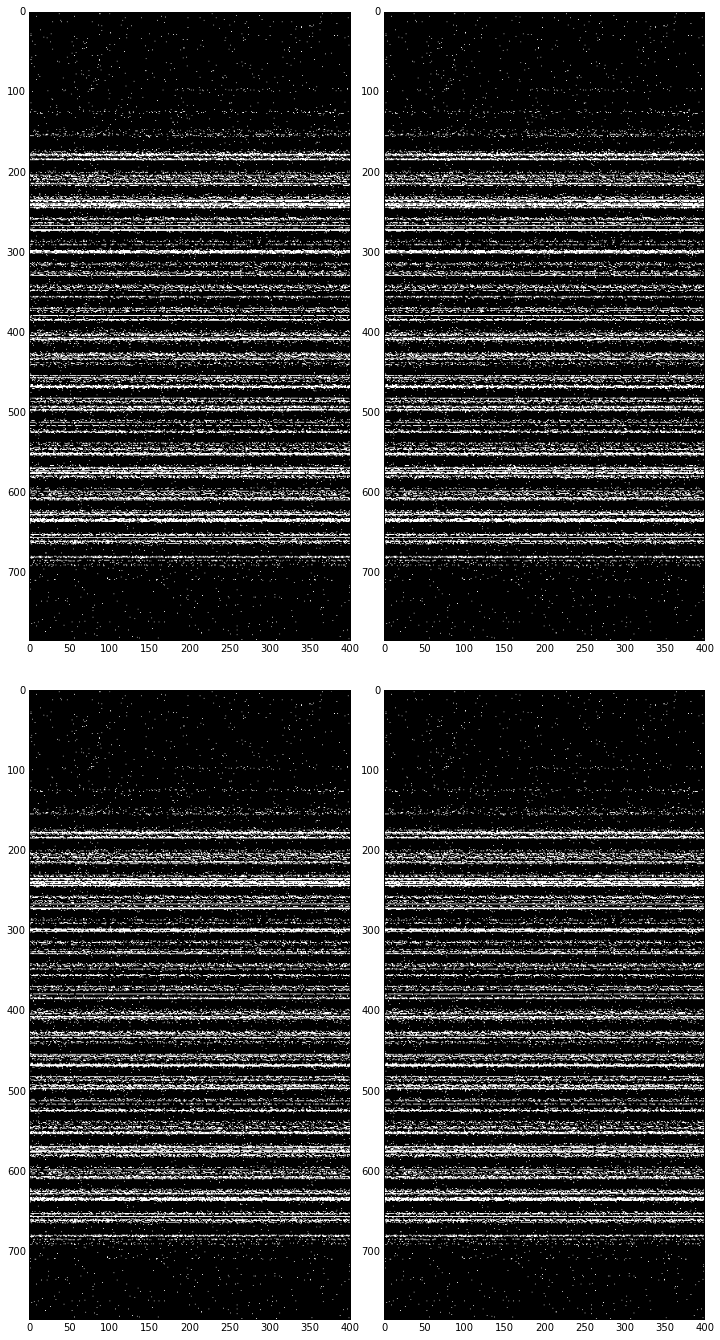

In [36]:
DPI = 40
fig = plt.figure(figsize=(N_SWEEP/DPI, n_dim/DPI), dpi=DPI)
for r in range(4):
    ax = fig.add_subplot(2, 2, r+1)
    ax.imshow(Xs[:,0,:].T, cmap=plt.cm.binary)
fig.tight_layout()